In [95]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
df_stock = pd.read_csv("maruti_suzuki/MARUTI.NS.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df_posts = pd.read_excel("maruti_suzuki/maruti_suzuki_final_posts.xlsx")
# removing the unnecessary columns
df_posts.drop(["Unnamed: 0"], axis=1,inplace=True)
# removing spam posts
df_posts = df_posts[df_posts.Spam==0.0]
df_posts.drop(["Spam"],axis=1,inplace=True)
# sliding a window of 7 days and adding all the TIs
from stock_helper import prepare_data
x,y = prepare_data(df_stock)
final_x = x[np.datetime64("2021-11-13"):]
final_y = y[np.datetime64("2021-11-13"):]
# reversing the posts data
df_posts = df_posts[::-1]
final_posts = df_posts[7:]
# loading the sentiment analysis model
sent_model = tf.keras.models.load_model("final_bert")
# removing duplicates from the data
final_posts.drop_duplicates(subset=['Messages'])
# calculating the sentiments score
sentiments = []
prev = np.datetime64("2015-11-12 21:31:26")
for i in final_y.index:
    total=0
    cnt=0
    for j in final_posts.itertuples():
        _,msg,time = j
        if np.datetime64(time)<np.datetime64(i) and np.datetime64(time)>prev:
            total += tf.squeeze(sent_model.predict([msg])).numpy()
            cnt+=1
    prev = np.datetime64(i)
    if(cnt==0):
        sentiments.append(0)
    else:
        sentiments.append(total/cnt)
# getting indices where sentiments score is 0
zero_index = []
for i,j in enumerate(sentiments):
    if(j==0):
        zero_index.append(i)
# removing all the zero values indices
sentiments = np.delete(sentiments,zero_index)
final_x_zeros = final_x.copy()
final_y_zeros = final_y.copy()
final_y_zeros = final_y_zeros.to_frame()
final_x_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros = final_y_zeros[final_y_zeros.removal_assist.isin(zero_index)==False]
final_x_zeros = final_x_zeros[final_x_zeros.removal_assist.isin(zero_index)==False]
# removing the added helper column
final_x_zeros.drop(["removal_assist"], axis=1,inplace=True)
final_y_zeros.drop(["removal_assist"], axis=1, inplace=True)

In [97]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_x_zeros=mms.fit_transform(final_x_zeros)
final_x_zeros

array([[0.41980076, 0.19144392, 0.17350197, ..., 0.57974905, 0.70709467,
        0.54999995],
       [0.36957264, 0.20892048, 0.2366209 , ..., 0.60375047, 0.7176312 ,
        0.54999995],
       [0.2905264 , 0.23642635, 0.33595848, ..., 0.5883486 , 0.6303451 ,
        0.54999995],
       ...,
       [0.95180225, 0.9424734 , 0.94618464, ..., 0.7914287 , 0.7590643 ,
        0.45      ],
       [0.96364975, 0.9706726 , 0.98105717, ..., 0.73870564, 0.7252364 ,
        0.45      ],
       [1.        , 1.        , 1.0000005 , ..., 0.668807  , 0.68463016,
        0.45      ]], dtype=float32)

In [98]:
k = final_y_zeros.max()
final_y_zeros= final_y_zeros/k
final_y_zeros

,Close
Date,
2021-11-15,0.838387
2021-11-16,0.899536
2021-11-17,0.924610
2021-11-18,0.907000
2021-11-22,0.878758
...,...
2022-02-07,0.951081
2022-02-08,0.960891
2022-02-09,1.000000


In [99]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=(71))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.1)(x)
x = tf.keras.layers.LSTM(128,return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(128)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs = inputs, outputs = output)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 71)]              0         
                                                                 
 lambda_12 (Lambda)          (None, 1, 71)             0         
                                                                 
 lstm_32 (LSTM)              (None, 1, 128)            102400    
                                                                 
 lstm_33 (LSTM)              (None, 1, 128)            131584    
                                                                 
 lstm_34 (LSTM)              (None, 128)               131584    
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 365,697
Trainable params: 365,697
Non-traina

In [100]:
model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(), metrics=["mse","mae"])

In [101]:
history = model.fit(t[:50],final_y_zeros[:50],
                    batch_size=32,
                    epochs = 1000)

Epoch 1/1000
2/2 [==============================] - 3s 15ms/step - loss: 0.8492 - mse: 0.7230 - mae: 0.8492
Epoch 2/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.8230 - mse: 0.6791 - mae: 0.8230
Epoch 3/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.7863 - mse: 0.6200 - mae: 0.7863
Epoch 4/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.7322 - mse: 0.5378 - mae: 0.7322
Epoch 5/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.6532 - mse: 0.4290 - mae: 0.6532
Epoch 6/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.5368 - mse: 0.2924 - mae: 0.5368
Epoch 7/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.3619 - mse: 0.1382 - mae: 0.3619
Epoch 8/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1534 - mse: 0.0316 - mae: 0.1534
Epoch 9/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.2076 - mse: 0.0667 - mae: 0.2076
Epoch 10/1000
2/2 [=========

2/2 [==============================] - 0s 10ms/step - loss: 0.0254 - mse: 9.8062e-04 - mae: 0.0254
Epoch 77/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0276 - mse: 0.0012 - mae: 0.0276
Epoch 78/1000
2/2 [==============================] - 0s 11ms/step - loss: 0.0246 - mse: 0.0010 - mae: 0.0246
Epoch 79/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0236 - mse: 8.7333e-04 - mae: 0.0236
Epoch 80/1000
2/2 [==============================] - 0s 10ms/step - loss: 0.0238 - mse: 8.6031e-04 - mae: 0.0238
Epoch 81/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0248 - mse: 9.7288e-04 - mae: 0.0248
Epoch 82/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0264 - mse: 0.0011 - mae: 0.0264
Epoch 83/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0242 - mse: 8.8290e-04 - mae: 0.0242
Epoch 84/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0276 - mse: 0.0013 - mae: 0.0276
Epoch 85/1000
2/2 [

2/2 [==============================] - 0s 8ms/step - loss: 0.0207 - mse: 6.8891e-04 - mae: 0.0207
Epoch 149/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0213 - mse: 7.7477e-04 - mae: 0.0213
Epoch 150/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0190 - mse: 5.7983e-04 - mae: 0.0190
Epoch 151/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0238 - mse: 8.8468e-04 - mae: 0.0238
Epoch 152/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0190 - mse: 5.4775e-04 - mae: 0.0190
Epoch 153/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0214 - mse: 7.8778e-04 - mae: 0.0214
Epoch 154/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0182 - mse: 5.0189e-04 - mae: 0.0182
Epoch 155/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0215 - mse: 7.5034e-04 - mae: 0.0215
Epoch 156/1000
2/2 [==============================] - 0s 10ms/step - loss: 0.0181 - mse: 6.3139e-04 - mae: 0.01

2/2 [==============================] - 0s 8ms/step - loss: 0.0139 - mse: 4.1463e-04 - mae: 0.0139
Epoch 221/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0188 - mse: 6.4404e-04 - mae: 0.0188
Epoch 222/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0192 - mse: 6.8733e-04 - mae: 0.0192
Epoch 223/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0149 - mse: 4.4702e-04 - mae: 0.0149
Epoch 224/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0174 - mse: 5.5762e-04 - mae: 0.0174
Epoch 225/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0170 - mse: 4.8366e-04 - mae: 0.0170
Epoch 226/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0137 - mse: 4.1145e-04 - mae: 0.0137
Epoch 227/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0159 - mse: 6.2000e-04 - mae: 0.0159
Epoch 228/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0164 - mse: 5.7734e-04 - mae: 0.016

2/2 [==============================] - 0s 8ms/step - loss: 0.0141 - mse: 4.0877e-04 - mae: 0.0141
Epoch 293/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0155 - mse: 5.3286e-04 - mae: 0.0155
Epoch 294/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0199 - mse: 5.7694e-04 - mae: 0.0199
Epoch 295/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0162 - mse: 5.0215e-04 - mae: 0.0162
Epoch 296/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0185 - mse: 7.0264e-04 - mae: 0.0185
Epoch 297/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0170 - mse: 5.2610e-04 - mae: 0.0170
Epoch 298/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0187 - mse: 6.0752e-04 - mae: 0.0187
Epoch 299/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0164 - mse: 4.7271e-04 - mae: 0.0164
Epoch 300/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0164 - mse: 5.1329e-04 - mae: 0.016

2/2 [==============================] - 0s 8ms/step - loss: 0.0112 - mse: 3.4780e-04 - mae: 0.0112
Epoch 365/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0139 - mse: 4.6561e-04 - mae: 0.0139
Epoch 366/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0156 - mse: 5.2982e-04 - mae: 0.0156
Epoch 367/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0140 - mse: 4.0005e-04 - mae: 0.0140
Epoch 368/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0127 - mse: 3.2677e-04 - mae: 0.0127
Epoch 369/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0134 - mse: 4.0649e-04 - mae: 0.0134
Epoch 370/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0124 - mse: 3.3452e-04 - mae: 0.0124
Epoch 371/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0146 - mse: 4.6823e-04 - mae: 0.0146
Epoch 372/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0141 - mse: 4.4127e-04 - mae: 0.014

2/2 [==============================] - 0s 8ms/step - loss: 0.0187 - mse: 5.8212e-04 - mae: 0.0187
Epoch 437/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0157 - mse: 4.4258e-04 - mae: 0.0157
Epoch 438/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0138 - mse: 3.8672e-04 - mae: 0.0138
Epoch 439/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0173 - mse: 4.7668e-04 - mae: 0.0173
Epoch 440/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0147 - mse: 5.5253e-04 - mae: 0.0147
Epoch 441/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0125 - mse: 4.1426e-04 - mae: 0.0125
Epoch 442/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0199 - mse: 6.1905e-04 - mae: 0.0199
Epoch 443/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0177 - mse: 5.6052e-04 - mae: 0.0177
Epoch 444/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0141 - mse: 4.7154e-04 - mae: 0.014

2/2 [==============================] - 0s 8ms/step - loss: 0.0144 - mse: 4.2707e-04 - mae: 0.0144
Epoch 509/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0111 - mse: 3.6355e-04 - mae: 0.0111
Epoch 510/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0118 - mse: 3.4153e-04 - mae: 0.0118
Epoch 511/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0135 - mse: 3.8862e-04 - mae: 0.0135
Epoch 512/1000
2/2 [==============================] - 0s 10ms/step - loss: 0.0120 - mse: 3.4465e-04 - mae: 0.0120
Epoch 513/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0140 - mse: 4.0308e-04 - mae: 0.0140
Epoch 514/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0158 - mse: 4.4698e-04 - mae: 0.0158
Epoch 515/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0154 - mse: 4.5192e-04 - mae: 0.0154
Epoch 516/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0110 - mse: 2.5999e-04 - mae: 0.01

2/2 [==============================] - 0s 8ms/step - loss: 0.0113 - mse: 2.4168e-04 - mae: 0.0113
Epoch 581/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0099 - mse: 2.7767e-04 - mae: 0.0099
Epoch 582/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0116 - mse: 3.2533e-04 - mae: 0.0116
Epoch 583/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0124 - mse: 3.4148e-04 - mae: 0.0124
Epoch 584/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0195 - mse: 4.9949e-04 - mae: 0.0195
Epoch 585/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0144 - mse: 3.6966e-04 - mae: 0.0144
Epoch 586/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0179 - mse: 5.0060e-04 - mae: 0.0179
Epoch 587/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0172 - mse: 4.5731e-04 - mae: 0.0172
Epoch 588/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0155 - mse: 4.3322e-04 - mae: 0.015

2/2 [==============================] - 0s 9ms/step - loss: 0.0124 - mse: 2.9533e-04 - mae: 0.0124
Epoch 653/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0131 - mse: 3.3400e-04 - mae: 0.0131
Epoch 654/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0108 - mse: 2.3658e-04 - mae: 0.0108
Epoch 655/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0097 - mse: 2.4861e-04 - mae: 0.0097
Epoch 656/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0115 - mse: 3.1868e-04 - mae: 0.0115
Epoch 657/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0105 - mse: 2.4230e-04 - mae: 0.0105
Epoch 658/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0126 - mse: 3.1473e-04 - mae: 0.0126
Epoch 659/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0123 - mse: 2.7601e-04 - mae: 0.0123
Epoch 660/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0102 - mse: 1.9296e-04 - mae: 0.010

2/2 [==============================] - 0s 9ms/step - loss: 0.0103 - mse: 2.0875e-04 - mae: 0.0103
Epoch 725/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0114 - mse: 2.5215e-04 - mae: 0.0114
Epoch 726/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0117 - mse: 2.9844e-04 - mae: 0.0117
Epoch 727/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0122 - mse: 2.7449e-04 - mae: 0.0122
Epoch 728/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0108 - mse: 2.7458e-04 - mae: 0.0108
Epoch 729/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0123 - mse: 2.7667e-04 - mae: 0.0123
Epoch 730/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0113 - mse: 3.0183e-04 - mae: 0.0113
Epoch 731/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0127 - mse: 2.8223e-04 - mae: 0.0127
Epoch 732/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0142 - mse: 3.5428e-04 - mae: 0.014

2/2 [==============================] - 0s 7ms/step - loss: 0.0100 - mse: 2.0207e-04 - mae: 0.0100
Epoch 797/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0145 - mse: 3.3146e-04 - mae: 0.0145
Epoch 798/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0126 - mse: 3.4763e-04 - mae: 0.0126
Epoch 799/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0137 - mse: 3.3862e-04 - mae: 0.0137
Epoch 800/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0126 - mse: 2.7051e-04 - mae: 0.0126
Epoch 801/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0105 - mse: 2.5686e-04 - mae: 0.0105
Epoch 802/1000
2/2 [==============================] - 0s 10ms/step - loss: 0.0151 - mse: 4.3283e-04 - mae: 0.0151
Epoch 803/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0135 - mse: 3.7121e-04 - mae: 0.0135
Epoch 804/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0119 - mse: 2.3389e-04 - mae: 0.01

2/2 [==============================] - 0s 9ms/step - loss: 0.0102 - mse: 2.1488e-04 - mae: 0.0102
Epoch 869/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0091 - mse: 1.9204e-04 - mae: 0.0091
Epoch 870/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0098 - mse: 1.8153e-04 - mae: 0.0098
Epoch 871/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0113 - mse: 3.0598e-04 - mae: 0.0113
Epoch 872/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0105 - mse: 1.9789e-04 - mae: 0.0105
Epoch 873/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0126 - mse: 2.6538e-04 - mae: 0.0126
Epoch 874/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0112 - mse: 2.4174e-04 - mae: 0.0112
Epoch 875/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0117 - mse: 2.5294e-04 - mae: 0.0117
Epoch 876/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0105 - mse: 2.0515e-04 - mae: 0.010

2/2 [==============================] - 0s 8ms/step - loss: 0.0093 - mse: 2.2334e-04 - mae: 0.0093
Epoch 941/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0108 - mse: 2.3803e-04 - mae: 0.0108
Epoch 942/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0138 - mse: 2.6946e-04 - mae: 0.0138
Epoch 943/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0094 - mse: 1.6297e-04 - mae: 0.0094
Epoch 944/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0109 - mse: 2.2074e-04 - mae: 0.0109
Epoch 945/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0131 - mse: 3.0143e-04 - mae: 0.0131
Epoch 946/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0106 - mse: 2.1722e-04 - mae: 0.0106
Epoch 947/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0100 - mse: 2.1094e-04 - mae: 0.0100
Epoch 948/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0098 - mse: 2.0343e-04 - mae: 0.009

In [103]:
preds = tf.squeeze(model.predict(t[50:])).numpy()

In [111]:
preds = preds*k.values[0]

<AxesSubplot:xlabel='Date'>

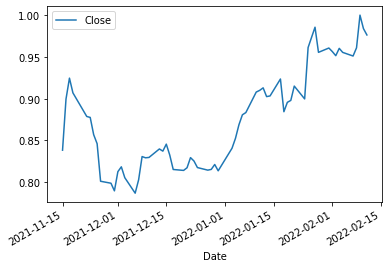

In [112]:
final_y_zeros.plot()

ValueError: x and y must have same first dimension, but have shapes (12,) and (13,)

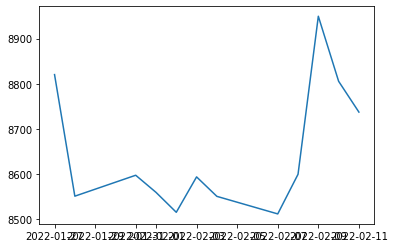

In [113]:
plt.plot(final_y_zeros.index[50:], final_y_zeros[50:]*k)
plt.plot(final_y_zeros.index[50:], preds)


In [116]:
z = tf.squeeze(final_y_zeros.to_numpy()).numpy()
z*k.values[0]

array([7503.1   , 8050.35  , 8274.75  , 8117.15  , 7864.4   , 7853.9995,
       7669.4507, 7572.5   , 7170.5   , 7149.5   , 7067.8   , 7273.25  ,
       7324.95  , 7208.7   , 7042.85  , 7186.6   , 7434.9   , 7421.75  ,
       7425.65  , 7516.4   , 7493.15  , 7567.95  , 7450.8   , 7296.6   ,
       7286.6   , 7315.15  , 7423.75  , 7387.15  , 7317.1   , 7289.5   ,
       7297.45  , 7350.05  , 7282.25  , 7523.9   , 7630.1   , 7775.35  ,
       7882.1   , 7906.    , 8125.6006, 8143.85  , 8170.75  , 8077.05  ,
       8084.2   , 8265.5   , 7915.15  , 8015.7   , 8036.35  , 8189.6   ,
       8052.3   , 8602.6   , 8820.2   , 8550.95  , 8597.3   , 8559.4   ,
       8515.25  , 8593.65  , 8550.55  , 8511.65  , 8599.45  , 8949.45  ,
       8805.45  , 8737.15  ], dtype=float32)

In [115]:
preds

array([7963.8354, 7932.399 , 7765.159 , 7603.1187, 7544.0137, 7538.2075,
       7497.7637, 7524.0234, 7598.5444, 7673.2217, 7686.795 , 7626.3013,
       7597.518 ], dtype=float32)

In [117]:
d = preds-z[50:]
d

ValueError: operands could not be broadcast together with shapes (13,) (12,) 

In [123]:
len(final_y_zeros[50:])

12